# Reddit Comment Sentiment Analysis

In [31]:
import tensorflow as tf
from keras import models, layers, optimizers, callbacks
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt
from twilio.rest import Client
from time import time
import datetime

## Part I - Load the Dataset

In [37]:
data_dir = "./data/Reddit_Data.csv"

comments = []
labels = []

with open(data_dir, 'r') as reddit:

    next(reddit) # the first line is the header

    reddit_reader = csv.reader(reddit, delimiter=',')
    for comment, label in reddit_reader:
        comments.append(comment.strip())
        labels.append(label)

labels = np.asarray(labels, dtype='int')

print(f'Found {len(comments)} comments with {len(labels)} labels.')

Found 37249 comments with 37249 labels.


Then convert the comments into fixed-length sequences by tokenization and padding:

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

max_length = 100  # each comment is trimmed to be at most 100-words long
max_words = 1000  # only the top 1000 most common words are used

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(comments)
seq_comments = tokenizer.texts_to_sequences(comments)

word_index = tokenizer.word_index
print(f"There are {len(word_index)} unique tokens (words) in this dataset.")

data = pad_sequences(seq_comments, maxlen=max_length)

print(f"The comments are now stored as a {str(type(data))} of shape {data.shape}")

There are 54719 unique tokens (words) in this dataset.
The comments are now stored as a <class 'numpy.ndarray'> of shape (37249, 100)


Then convert the numerical labels (-1, 0, 1) into one-hot labels:

In [39]:
def to_one_hot(labels, encoder, dimension=None):
    if dimension is None:
        dimension = len(set(labels))
    results = np.zeros((len(labels), dimension))
    for i, label in tqdm(enumerate(labels), total=dimension):
        results[i, encoder[label]] = 1.
    return results

encoder = {i:(i+1) for i in [-1,0,1]}  
# the encoder maps the original label to the index of the 1 in its one-hot
# that is, a label of 1 corresponds to the one-hot [0,0,1], so it is mapped to 2

labels_OH = to_one_hot(labels, encoder)
print(f"The labels are now stored as a {str(type(labels_OH))} of shape {labels_OH.shape}")

  0%|          | 0/3 [00:00<?, ?it/s]

The labels are now stored as a <class 'numpy.ndarray'> of shape (37249, 3)


## Part II - Preparing the Embedding  
First, we load the [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/) embedding into a dictionary containing (<ins>word</ins> : <ins>coefficient</ins>) pairs.  

Here we use the 50-dimension version of GloVe (that is, each coefficient vector will contain 50 entries).

In [36]:
glove_dir = './glove.6B/glove.6B.50d.txt'

embeddings = {}
with open(glove_dir) as glove:
    for line in tqdm(glove, total=400000):
        spline = line.split(' ')
        word = spline[0]
        coef = np.asarray(spline[1:], dtype='float')
        embeddings[word] = coef

print(f'''The embeddings dictionary contains {embeddings["the"].shape[0]}-dimension coefficient vectors that represent {len(embeddings)} words.''')

  0%|          | 0/400000 [00:00<?, ?it/s]

The embeddings dictionary contains 50-dimension coefficient vectors that represent 400000 words.


Then, we collect the coefficients of the most frequent words in our sample, and organize them into a numpy array.

In [40]:
# the following function is adapted from Francois Chollet's book

embedding_matrix = np.zeros((max_words, 50))  # each row is the 50-dimensional GloVe embedding of a word

for word, index in word_index.items():
    if index < max_words:  # if the word is among the top 10000 most frequent words
        embedding = embeddings.get(word)
        if embedding is not None:
            embedding_matrix[index,:] = embedding

Finally, we shuffle the data and split it into a train and a validation set.

In [41]:
shuffled = np.random.permutation(range(len(labels)))
shuffled_comments = data[shuffled]
shuffled_labels = labels_OH[shuffled]

In [42]:
n_samples = len(labels)

train_proportion = 0.8
train_size = int(np.round(n_samples * train_proportion))

train_data = shuffled_comments[:train_size]
train_labels = shuffled_labels[:train_size]

valid_data = shuffled_comments[train_size:]
valid_labels = shuffled_labels[train_size:]

print(f'''The training set contains {train_size} ({int(100*train_proportion)}%) samples,
while the validation contains the remaining {n_samples-train_size} ({int(100*train_proportion)}%).''')

The training set contains 29799 (80%) samples,
while the validation contains the remaining 7450 (80%).


## Part III - Building the Model

In [43]:
model = models.Sequential([
    layers.Embedding(max_words, 50, input_length=max_length),
    layers.Conv1D(32, 7, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Bidirectional(layers.LSTM(16, return_sequences=True, recurrent_regularizer='l1')),
    layers.Bidirectional(layers.LSTM(16, return_sequences=True, recurrent_regularizer='l1')),
    layers.Bidirectional(layers.LSTM(16, return_sequences=True, recurrent_regularizer='l1')),
    layers.Bidirectional(layers.LSTM(16, recurrent_regularizer='l1')),
    layers.Dense(3, activation='softmax')
])

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 50)           50000     
                                                                 
 conv1d_6 (Conv1D)           (None, 94, 32)            11232     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 31, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_24 (Bidirecti  (None, 31, 32)           6272      
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 31, 32)           6272      
 onal)                                                           
                                                      

In [44]:
model.compile(loss='categorical_crossentropy',
            optimizer='Adam',
            metrics=['acc'])

log_dir = 'logs'

Building the CallBack list:

In [45]:
# this is a bot that sends WhatsApp messages about each epoch
# if you have a Twilio account, replace the sid and token with your own, as well as the phone numbers;
# if not, just remove it from the call back list

def message_me(message='EMPTY',
                sid='YOUR_SID', 
                token='YOUR_AUTH_TOKEN'):

    client = Client(sid, token)

    message = client.messages \
        .create(
            body=message,
            from_='whatsapp:YOUR_TWILIO_NUMBER',
            to='whatsapp:YOUR_OWN_NUMBER'
        )

    return message.sid

class message_updates(callbacks.Callback):

    def __init__(self):
        self.previousvac = 0
        self.bestvac = 0
        self.improving = True
        self.streak = 0
        message_me(message='='*5+' NEW INSTANCE '+'='*5)

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime=time()
    
    def on_epoch_end(self, epoch, logs={}):
        vac = round(logs['val_acc'], 4)

        # records consistent improvement/degradation:
        if (self.previousvac < vac) == self.improving:
            self.streak += 1
        else:
            self.improving = not self.improving
            self.streak = 1
        self.previousvac = vac

        if self.bestvac < vac:
            self.bestvac = vac
            current_best = True
        else:
            current_best = False

        arr =  "⤒" if current_best else ('↑' if self.improving else '↓')
        accuracy_report = f'{vac} ({str(self.streak)+arr})'

        lr = round(float(self.model.optimizer.lr), 4)

        epoch_length = round(time()-self.starttime)
        format_length = str(datetime.timedelta(seconds=epoch_length))

        message = (f"EPOCH {epoch+1}\n" + f"• Validation Accuracy : {accuracy_report}\n"
        + f"• Time : {format_length}s\n"
        + f"• Learning Rate : {lr}")

        message_me(message)
        
        return

callback_list = [
    callbacks.TensorBoard(
        log_dir = log_dir,
        histogram_freq = 1,
        embeddings_freq = 1),
    callbacks.ModelCheckpoint(
       filepath = 'BestModel.h5',
       monitor = 'val_loss',
       save_best_only = True),
    callbacks.EarlyStopping(
        monitor = 'val_acc',
        patience = 4),
    callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.1,
        patience = 4),
    message_updates()
    ]

Finally, we fit the model and verify it on validation data.

In [46]:
history = model.fit(train_data, train_labels,
                    epochs = 40,
                    batch_size = 128,
                    validation_data =  (valid_data, valid_labels),
                    validation_batch_size= 128,
                    callbacks = callback_list)

save_dir = 'FinalModel'
model.save(save_dir)
message_me(message = '='*5 + ' TRAINING ENDS ' + '='*5)

Epoch 1/40


2022-10-17 23:26:29.954105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:26:40.145720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:26:40.198652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:26:43.890529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:26:43.923230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:26:44.612762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:26:44.658869: I tensorflow/core/grappler/optimizers/cust

  6/233 [..............................] - ETA: 12:26 - loss: 9.0971 - acc: 0.3906WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 3.2193s vs `on_train_batch_end` time: 6.4120s). Check your callbacks.


233/233 [==============================] - ETA: 0s - loss: 3.6262 - acc: 0.6076

2022-10-17 23:29:29.120243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:29:31.289541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:29:31.323195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:29:32.112427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:29:32.136157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:29:32.857585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-17 23:29:32.885292: I tensorflow/core/grappler/optimizers/cust

233/233 [==============================] - 205s 549ms/step - loss: 3.6262 - acc: 0.6076 - val_loss: 1.0159 - val_acc: 0.6620 - lr: 0.0010
Epoch 2/40
233/233 [==============================] - 78s 331ms/step - loss: 0.7546 - acc: 0.7109 - val_loss: 0.6694 - val_acc: 0.7373 - lr: 0.0010
Epoch 3/40
233/233 [==============================] - 71s 304ms/step - loss: 0.6178 - acc: 0.7663 - val_loss: 0.6350 - val_acc: 0.7608 - lr: 0.0010
Epoch 4/40
233/233 [==============================] - 71s 304ms/step - loss: 0.5701 - acc: 0.7939 - val_loss: 0.6287 - val_acc: 0.7626 - lr: 0.0010
Epoch 5/40
233/233 [==============================] - 107s 457ms/step - loss: 0.5433 - acc: 0.8068 - val_loss: 0.6232 - val_acc: 0.7616 - lr: 0.0010
Epoch 6/40
233/233 [==============================] - 119s 505ms/step - loss: 0.5225 - acc: 0.8170 - val_loss: 0.6307 - val_acc: 0.7634 - lr: 0.0010
Epoch 7/40
233/233 [==============================] - 142s 606ms/step - loss: 0.5002 - acc: 0.8267 - val_loss: 0.6457 - 

INFO:tensorflow:Assets written to: reddit_sentiment/assets


INFO:tensorflow:Assets written to: reddit_sentiment/assets


'SM82cff7467a23fe9a7be7339433748863'

### Inspecting the Model

Plotting the accuracies and losses:

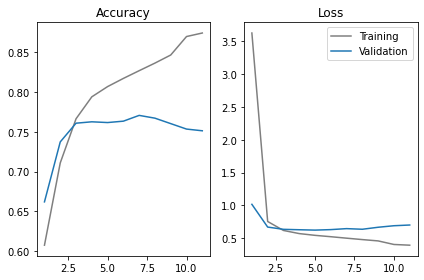

In [47]:
# the following function is adapted from Francois Chollet's book

def plot_performance(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'C7')
    plt.plot(epochs, val_acc, 'C0')
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'C7', label='Training')
    plt.plot(epochs, val_loss, 'C0', label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_performance(history)

In [18]:
%load_ext tensorboard
%tensorboard --logdir=logs --host localhost --port 8008

# visit localhost:8088 to explore the model with tensorboard

Reusing TensorBoard on port 8088 (pid 19224), started 1 day, 22:15:41 ago. (Use '!kill 19224' to kill it.)